In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [7]:
from pathlib import Path
from matplotlib import pyplot as plt
from collections import defaultdict
from datetime import datetime as dt
from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np
from scipy.integrate import cumtrapz
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

In [5]:
df = pd.read_csv('batterieDataPériode4.csv', low_memory = False)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df

,TIMESTAMP,Batt_Li_Voltage,Batt_Li_Current,Batt_Li_Power,Batt_Li_SoC,PV_Voltage,PV_Power,Batt_Li_SetPower_EMS
0,2022-07-27 11:42:30,26.57,0.000,0.00,0.0,28.47,0,0.00
1,2022-07-27 11:42:35,26.54,0.000,0.00,0.0,28.46,0,0.00
2,2022-07-27 11:42:40,26.53,0.000,0.00,0.0,28.45,0,0.00
3,2022-07-27 11:42:45,26.52,0.000,0.00,0.0,28.44,0,0.00
4,2022-07-27 11:42:50,26.51,0.000,0.00,0.0,28.43,0,0.00
...,...,...,...,...,...,...,...,...
95244,2022-08-01 23:59:35,27.46,0.185,5.08,94.3,27.42,0.0,0.08
95245,2022-08-01 23:59:40,27.46,0.185,5.08,94.3,27.41,0.0,0.08
95246,2022-08-01 23:59:45,27.47,-0.084,-2.31,94.3,27.43,0.0,0.08
95247,2022-08-01 23:59:50,27.46,0.186,5.11,94.3,27.41,0.0,0.08


In [16]:
df['Batt_Li_Voltage'].describe()

count    95249.000000
mean        27.137425
std          0.842587
min         25.270000
25%         26.460000
50%         26.860000
75%         28.220000
max         28.700000
Name: Batt_Li_Voltage, dtype: float64

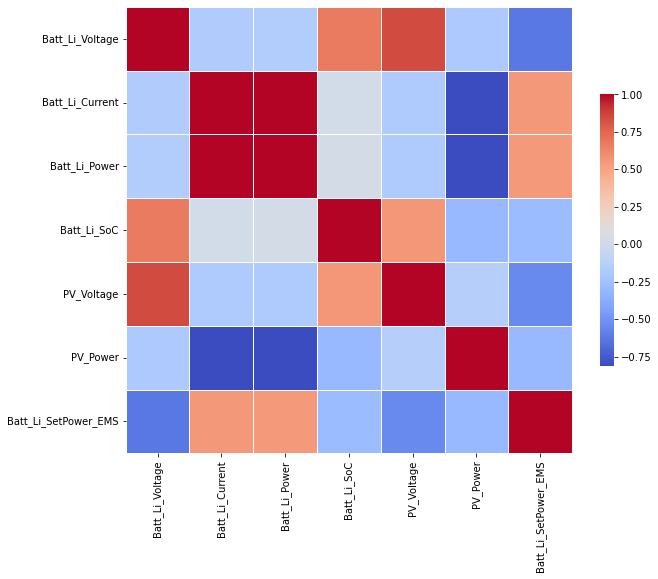

In [28]:
df_normalized = df.drop(['TIMESTAMP'],axis=1)
scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df_normalized))
cols = df.columns[1:]
df_normalized.columns = cols

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df_normalized.corr(), cmap='coolwarm', fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()
fig.savefig('Correlation between data')

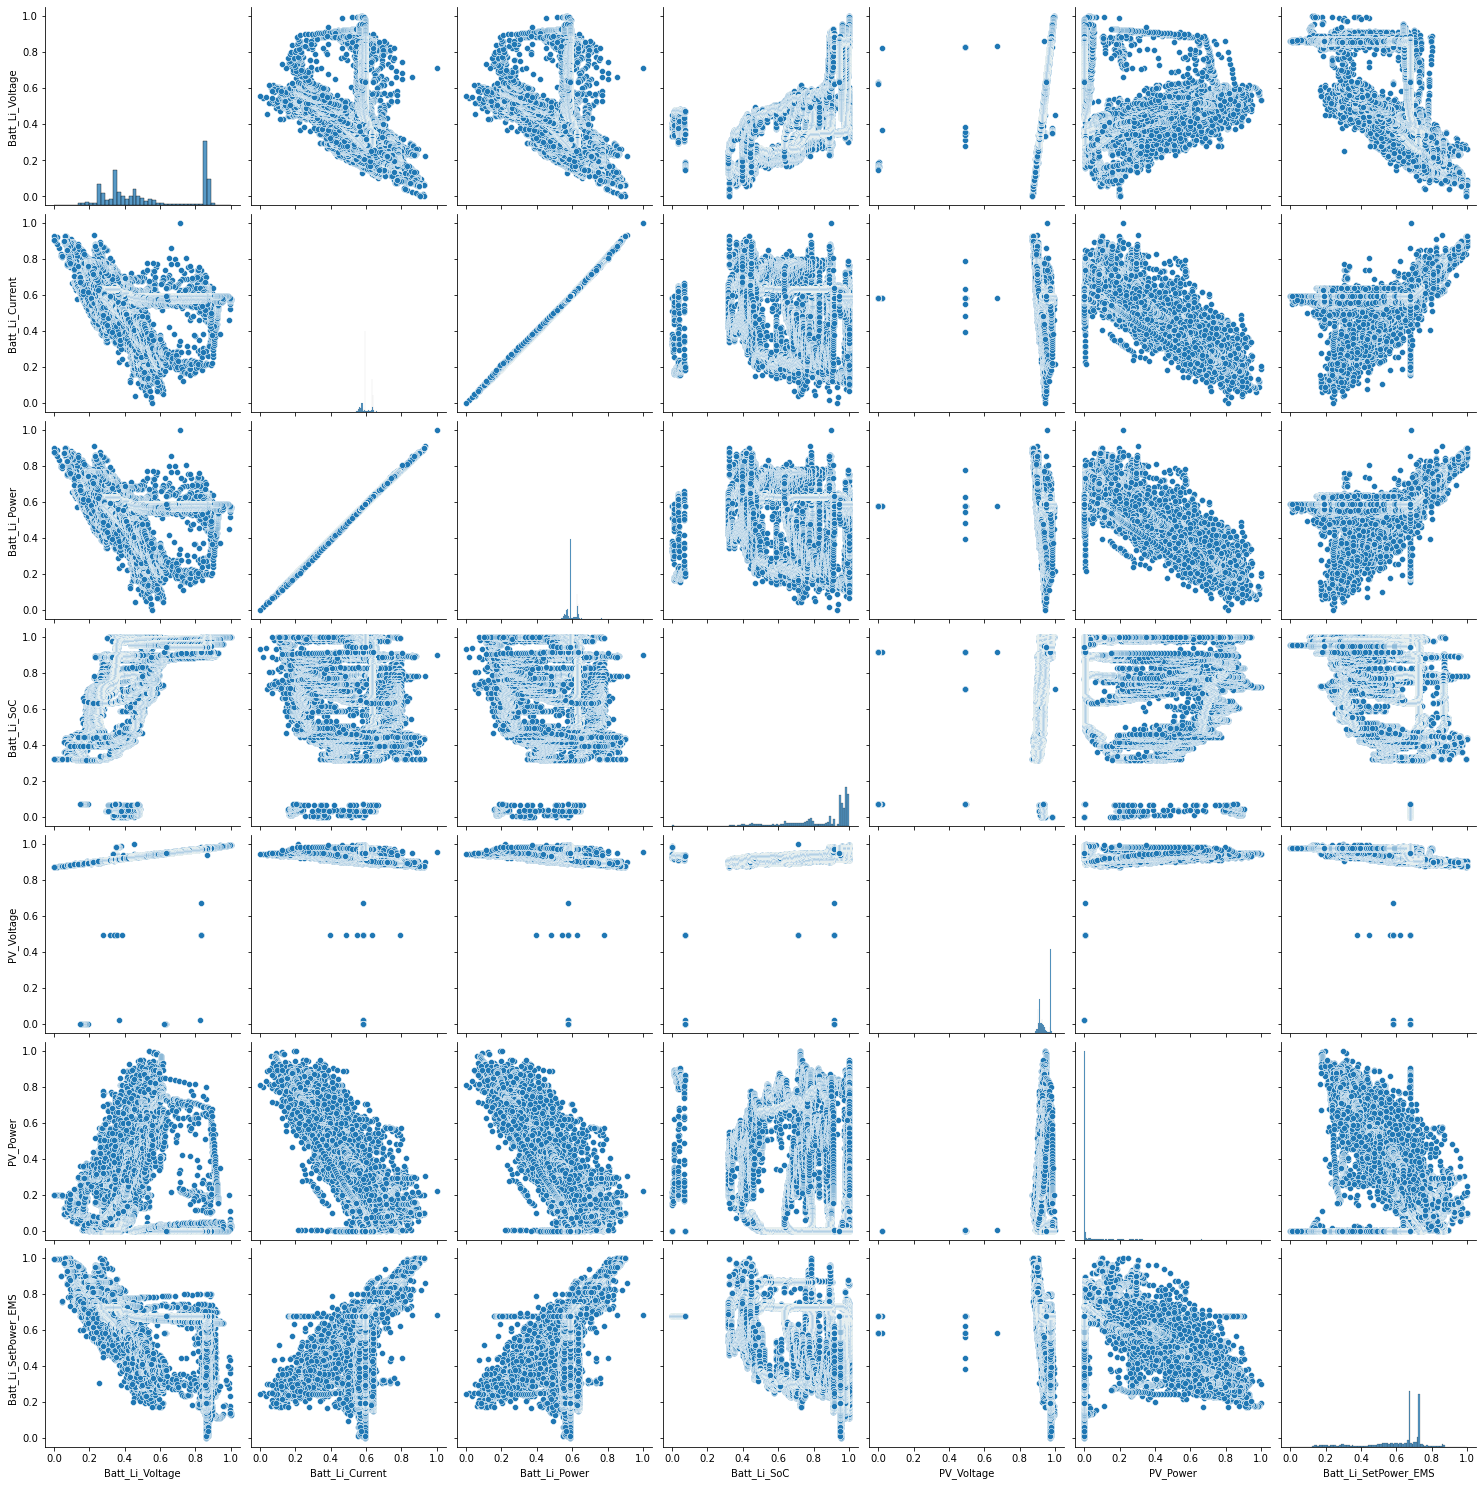

In [8]:
sns.pairplot(df_normalized, height=3)

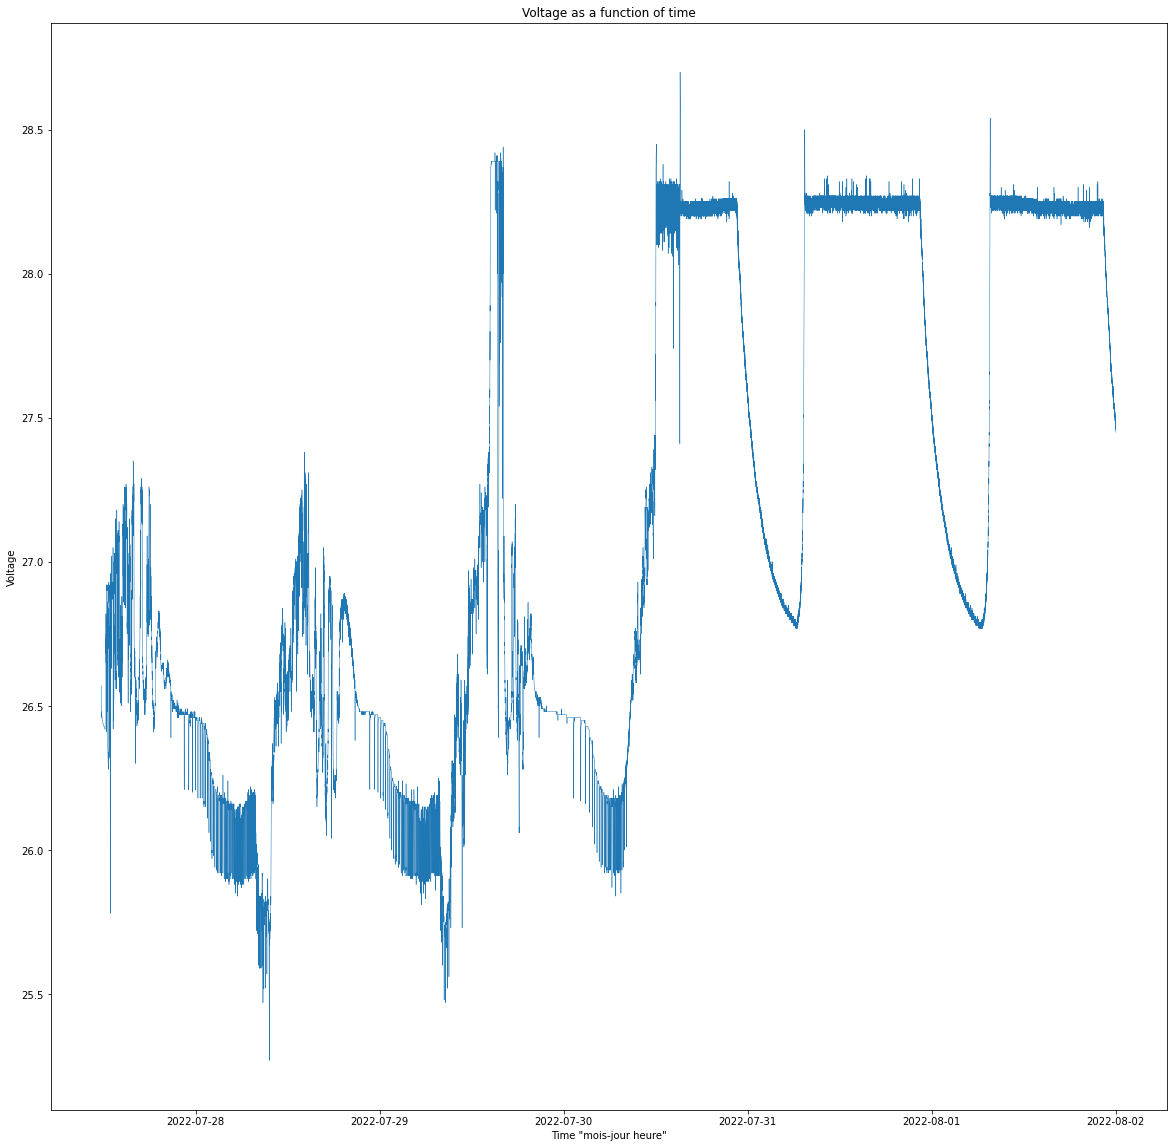

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Voltage'],linewidth=0.5, markersize=0.05)

ax.set_title('Voltage as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Voltage')
fig.savefig('Voltage as a function of time during fourth period')

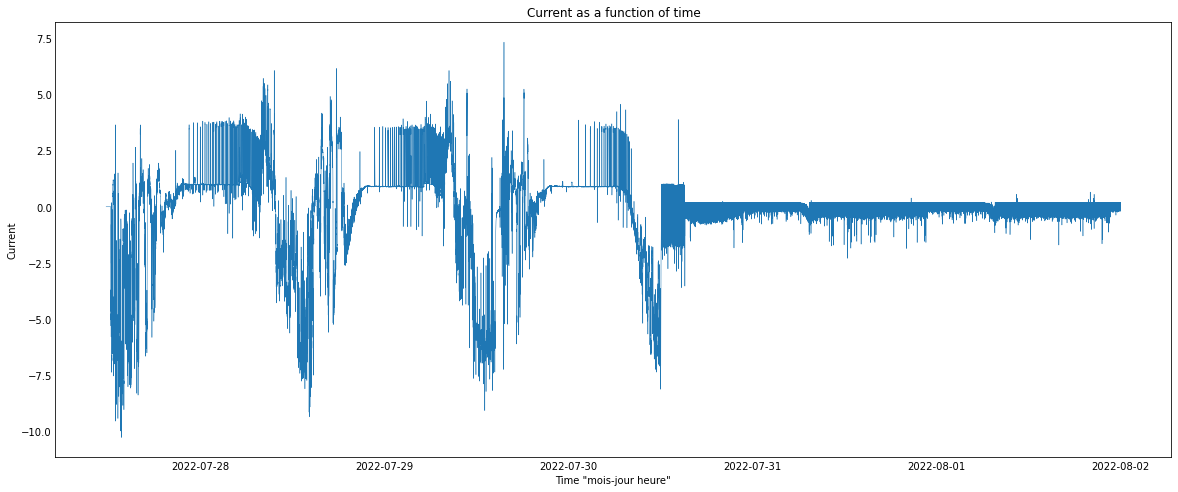

In [30]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Current'],linewidth=0.5, markersize=0.05)

ax.set_title('Current as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Current')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Current as a function of time during fourth period')

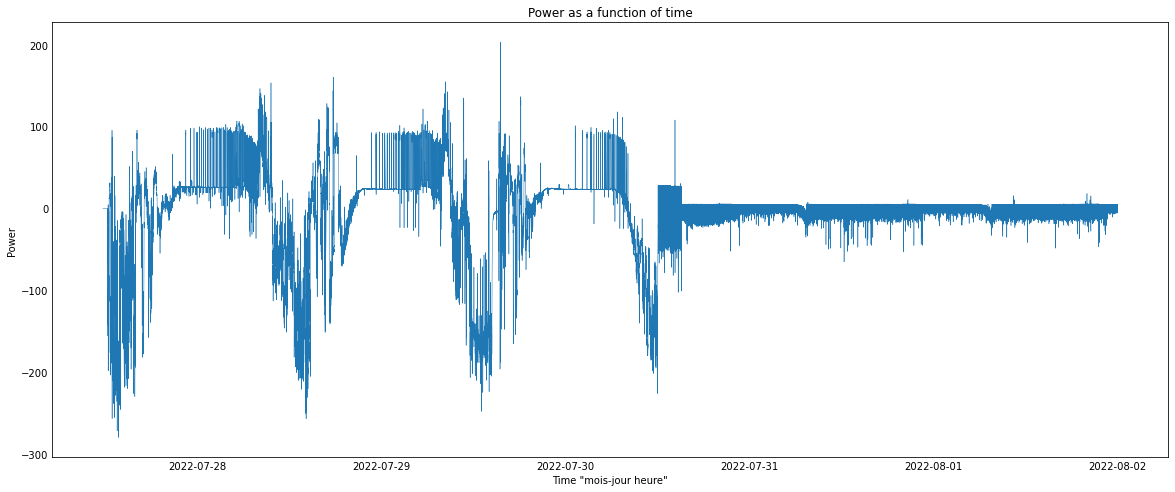

In [31]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_Power'],linewidth=0.5, markersize=0.05)

ax.set_title('Power as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Power')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Power as a function of time during fourth period')

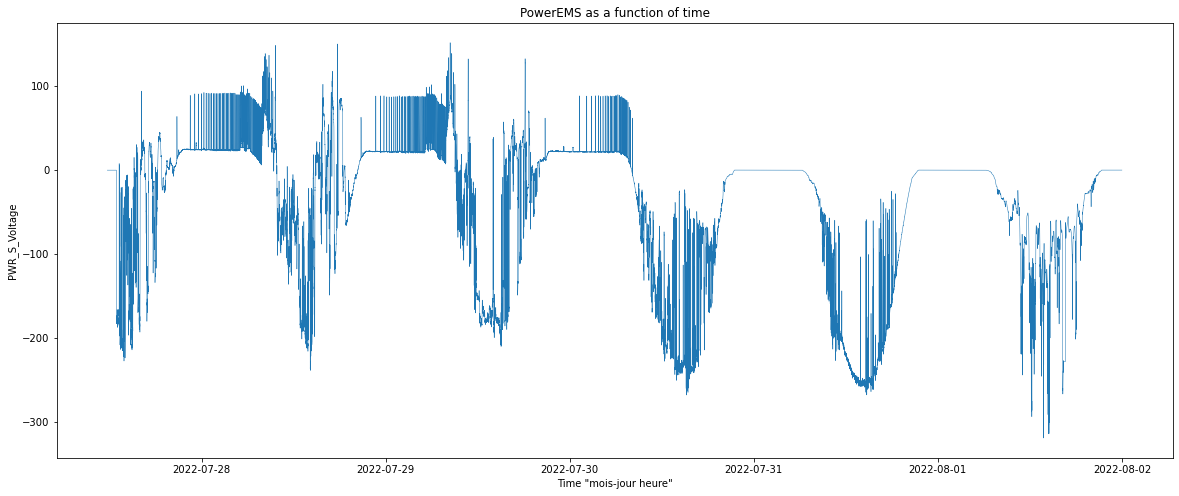

In [32]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_SetPower_EMS'], linewidth=0.5, markersize=0.05)

ax.set_title('PowerEMS as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('PWR_S_Voltage')
fig.savefig('Power EMS as a function of time during fourth period')

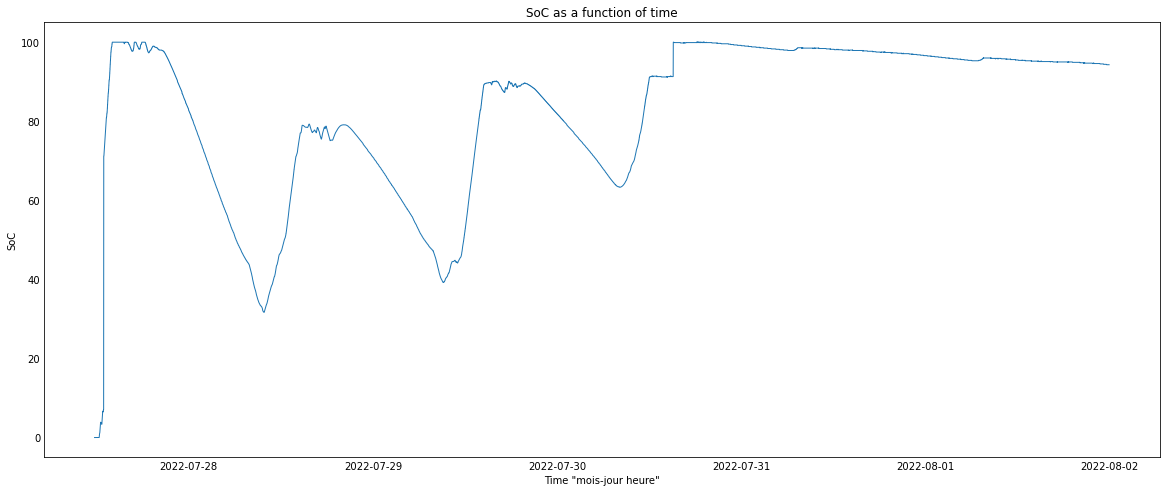

In [33]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['Batt_Li_SoC'],linewidth=1, markersize=0.5)

ax.set_title('SoC as a function of time')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('SoC')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('SoC as a function of time during fourth period')

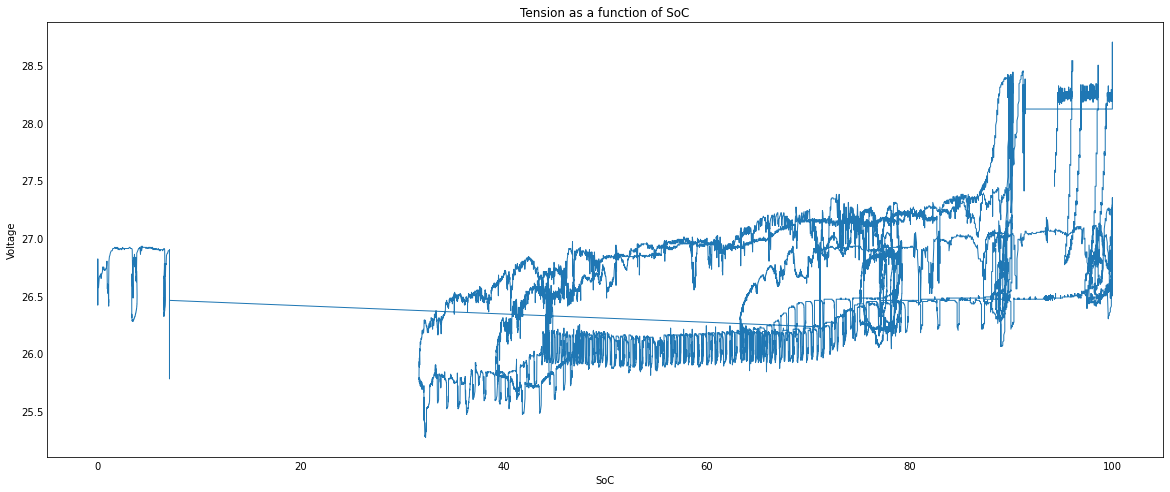

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['Batt_Li_SoC'], df['Batt_Li_Voltage'],linewidth=1, markersize=0.5)

ax.set_title('Tension as a function of SoC')
ax.set_xlabel('SoC')
ax.set_ylabel('Voltage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Tension as a function of SoC during fourth period')

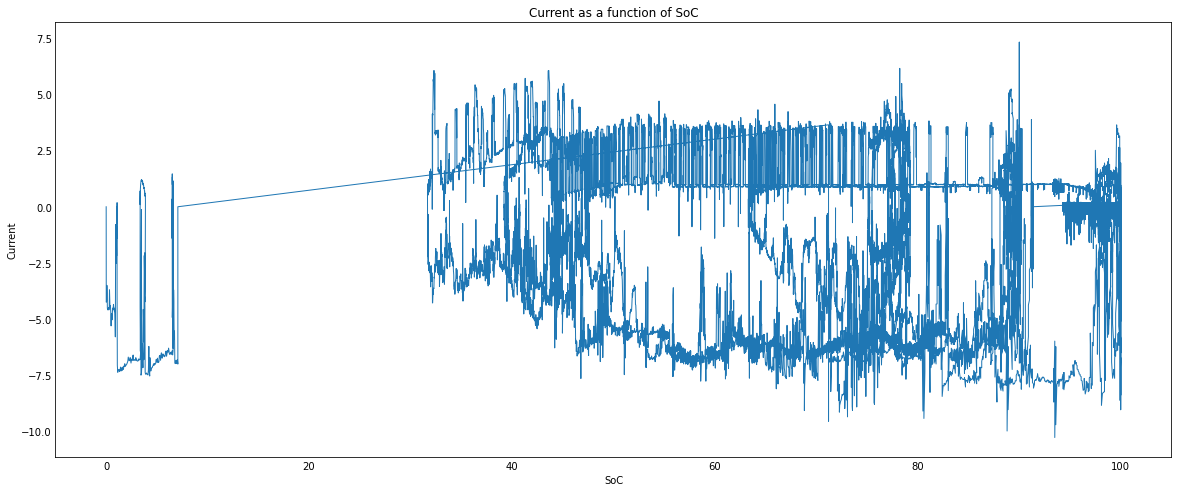

In [18]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['Batt_Li_SoC'], df['Batt_Li_Current'],linewidth=1, markersize=0.5)

ax.set_title('Current as a function of SoC')
ax.set_xlabel('SoC')
ax.set_ylabel('Current')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Current as a function of SoC during fourth period')

In [8]:
C_nom = 8
def state_of_charge(df):
    I = df['Batt_Li_Current']  # courant aux bornes de la batterie
    V = df['Batt_Li_Voltage']  # tension aux bornes de la batterie
    t = (df['TIMESTAMP'] - df['TIMESTAMP'].iloc[0]).dt.total_seconds()  # temps écoulé depuis le début des mesures en secondes
    Q = np.cumsum(I) * (t.diff().fillna(1))  # charge totale en Ah
    SOC = -(Q / C_nom)/100  # état de charge en pourcentage
    return SOC
df1 = df
df1['SoC_Tension'] = state_of_charge(df)
max_variation = 10
variations = df1['SoC_Tension'].diff()

lignes_a_supprimer = df1.loc[variations > max_variation].index
df1 = df1.drop(lignes_a_supprimer)



In [26]:
def state_of_health(df):
    I = df['Batt_Li_Current']  # courant aux bornes de la batterie
    V = df['Batt_Li_Voltage']  # tension aux bornes de la batterie
    t = (df['TIMESTAMP'] - df['TIMESTAMP'].iloc[0]).dt.total_seconds()  # temps écoulé depuis le début des mesures en secondes
    Q = np.cumsum(I) * (t.diff().fillna(1))  # charge totale en Ah
    C = Q.iloc[-1] / (V.iloc[-1] - V.iloc[0])  # capacité réelle en Ah
    SOH = (C / C_nom) / 100  # état de santé en pourcentage
    return SOH


In [16]:
delta_t = np.diff(df['TIMESTAMP'])

# ajouter un zéro en début de tableau pour prendre en compte la première mesure
delta_t = np.insert(delta_t, 0, 0)

# calculer l'intégrale de la colonne de données en fonction du temps
integrale = cumtrapz(df['Batt_Li_SetPower_EMS'], delta_t, initial=0)

# ajouter la colonne d'intégrale au DataFrame
df['SoC_integrale_Pwr'] = integrale

In [18]:
def calculer_integrale(row):
    return cumtrapz(row['Batt_Li_SetPower_EMS'], row['TIMESTAMP'], initial=0)[-1]
df['SoC_integrale_Pwr'] = df.apply(calculer_integrale, axis=1)

ValueError: diff requires input that is at least one dimensional

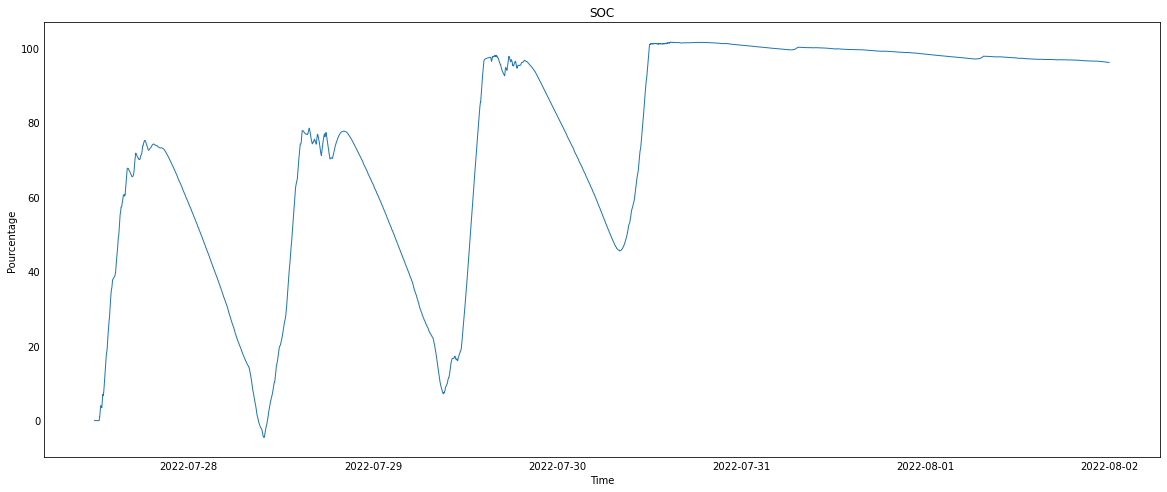

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df1['TIMESTAMP'], df1['SoC_Tension'], label='SOC',linewidth=1)

ax.set_title('SOC')
ax.set_xlabel('Time')
ax.set_ylabel('Pourcentage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('SoC determined with tension as a function of SoC during fourth period')

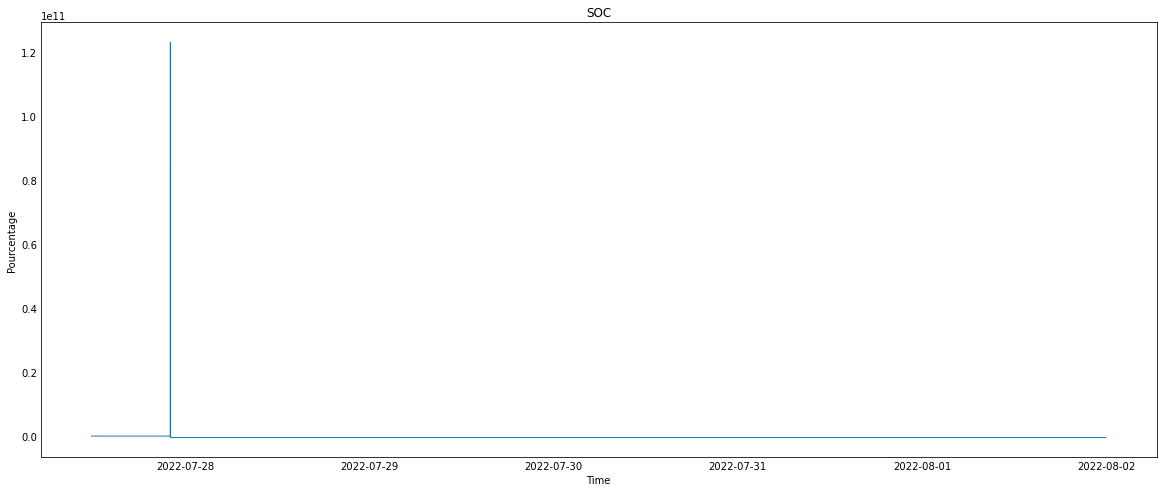

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df['TIMESTAMP'], df['SoC_integrale_Pwr'], label='SOC',linewidth=1)

ax.set_title('SOC')
ax.set_xlabel('Time')
ax.set_ylabel('Pourcentage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Current as a function of SoC during fourth period')

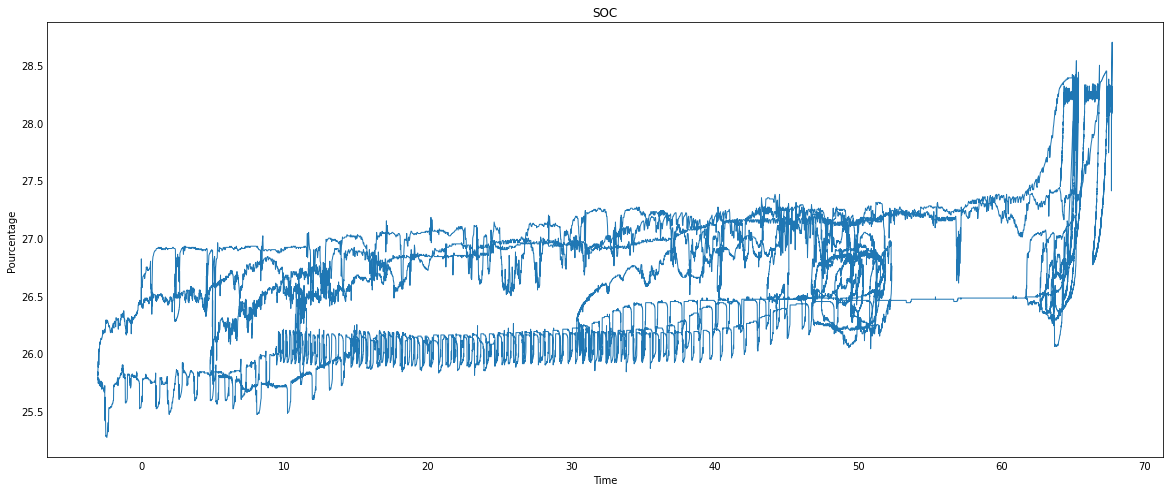

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df1['SoC_Tension'], df1['Batt_Li_Voltage'], label='SOC',linewidth=1)

ax.set_title('SOC')
ax.set_xlabel('Time')
ax.set_ylabel('Pourcentage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Current as a function of SoC during fourth period')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df1['TIMESTAMP'], df1['SoC_Tension'], label='SOC',linewidth=1)

ax.set_title('SOC')
ax.set_xlabel('Time')
ax.set_ylabel('Pourcentage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('Current as a function of SoC during fourth period')

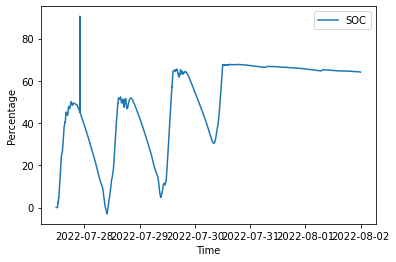

In [47]:
plt.plot(df['TIMESTAMP'], state_of_charge(df), label='SOC')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (95249,) and (1,)

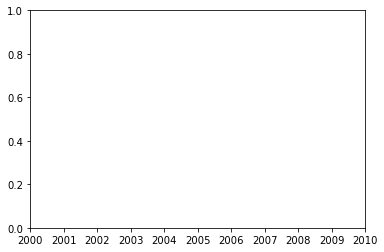

In [10]:
plt.plot(df['TIMESTAMP'], state_of_health(df), label='SOH')

In [21]:
capacite_batterie = 12.799999999999999 # en Ah
tension_nominal = 15.6 # en V
df['etat_de_charge'] = (df['Batt_Li_Voltage'] - tension_nominal) / (0.1 * capacite_batterie) * 100
df

,TIMESTAMP,Batt_Li_Voltage,Batt_Li_Current,Batt_Li_Power,Batt_Li_SoC,PV_Voltage,PV_Power,Batt_Li_SetPower_EMS,etat_de_charge
0,2022-07-27 11:42:30,26.57,0.000,0.00,0.0,28.47,0,0.00,857.03125
1,2022-07-27 11:42:35,26.54,0.000,0.00,0.0,28.46,0,0.00,854.68750
2,2022-07-27 11:42:40,26.53,0.000,0.00,0.0,28.45,0,0.00,853.90625
3,2022-07-27 11:42:45,26.52,0.000,0.00,0.0,28.44,0,0.00,853.12500
4,2022-07-27 11:42:50,26.51,0.000,0.00,0.0,28.43,0,0.00,852.34375
...,...,...,...,...,...,...,...,...,...
95244,2022-08-01 23:59:35,27.46,0.185,5.08,94.3,27.42,0.0,0.08,926.56250
95245,2022-08-01 23:59:40,27.46,0.185,5.08,94.3,27.41,0.0,0.08,926.56250
95246,2022-08-01 23:59:45,27.47,-0.084,-2.31,94.3,27.43,0.0,0.08,927.34375
95247,2022-08-01 23:59:50,27.46,0.186,5.11,94.3,27.41,0.0,0.08,926.56250


In [9]:
import numpy as np

# créer un tableau de données
x = np.array([1, 2, 3, 4, 5])

# calculer l'intégrale de la fonction x en utilisant cumtrapz
integrale = np.cumtrapz(x)

# afficher l'intégrale
print(integrale)

AttributeError: module 'numpy' has no attribute 'cumtrapz'

ValueError: x and y must have same first dimension, but have shapes (95249,) and (1,)

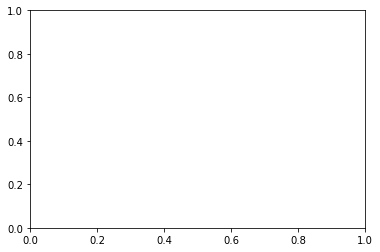

In [5]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']).apply(lambda x: int(x.timestamp()))

# Calculate the power at each time point
df['exp_power'] = df['Batt_Li_Voltage'] * df['Batt_Li_Current']

# Calculate the total energy over time
total_energy = np.trapz(df['exp_power'], df['TIMESTAMP']) / 3600 # convert to watt-hours

# Calculate the SOC
nominal_capacity = 24 # Ah
soc = total_energy / nominal_capacity

# Plot the SOC over time
plt.plot(df['TIMESTAMP'], soc)
plt.xlabel('Time')
plt.ylabel('State of Charge')
plt.show()

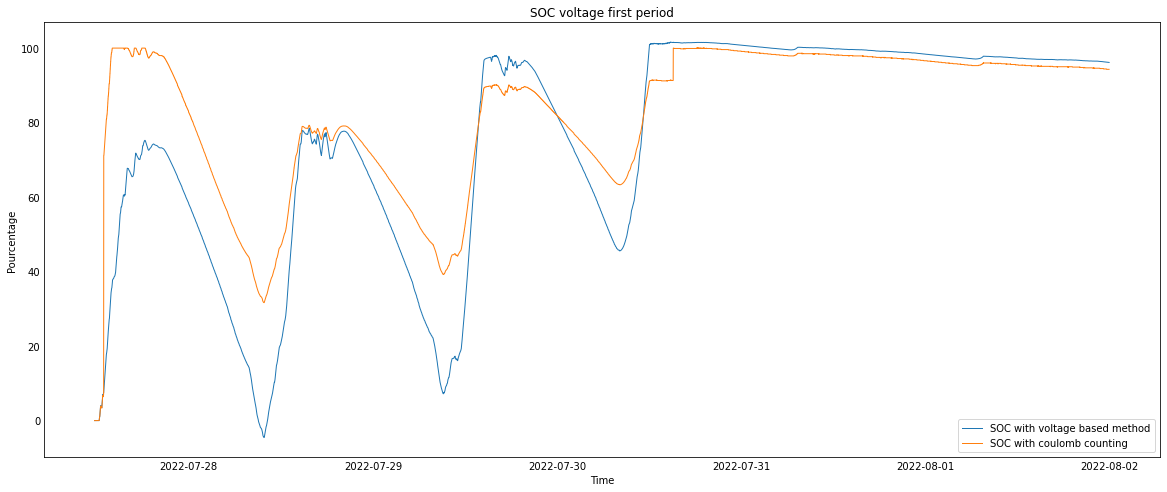

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(df1['TIMESTAMP'], df1['SoC_Tension'], label='SOC with voltage based method',linewidth=1)
ax.plot(df['TIMESTAMP'], df['Batt_Li_SoC'],label='SOC with coulomb counting',linewidth=1, markersize=0.5)

ax.set_title('SOC voltage first period')
ax.set_xlabel('Time')
ax.set_ylabel('Pourcentage')
ax.tick_params(axis='both', which='both', length=0)
fig.savefig('SoC determined with tension as a function of SoC during first period')
plt.legend()

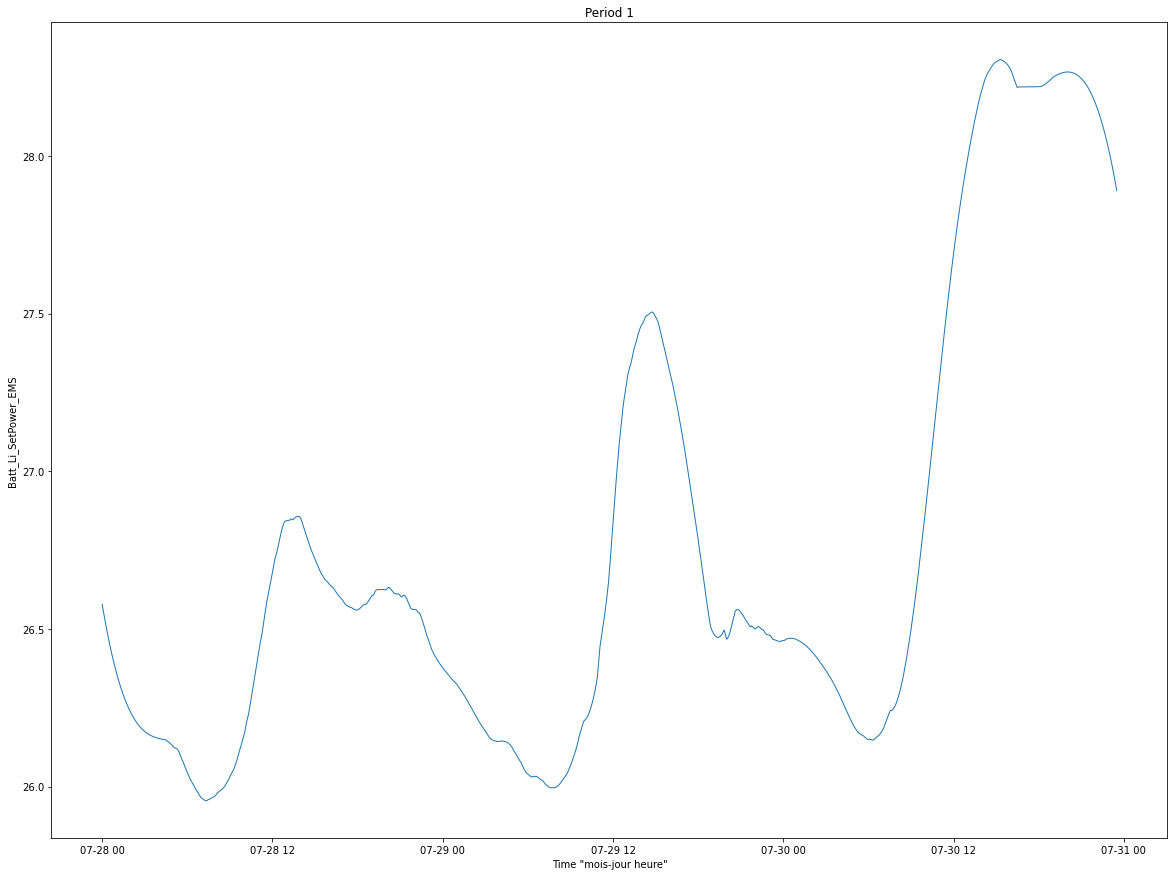

In [15]:
start_date = '2022-07-28 00:00:00'
end_date = '2022-07-30 23:30:00'

df_period = df.loc[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date), ['TIMESTAMP', 'Batt_Li_Voltage']]

fig, ax = plt.subplots(figsize=(20, 15))
a = len(df_period['Batt_Li_Voltage']-1)
a = a/8
a = int(a)
if(a%2 == 0):
    a = a+1
Lisse = savgol_filter(df_period['Batt_Li_Voltage'],a , 3)

#ax.plot(df_period['TIMESTAMP'], df_period['Batt_Li_Voltage'], label='voltage-lisse',linewidth=1)
ax.plot(df_period['TIMESTAMP'], Lisse, label='voltage-lisse',linewidth=1)

ax.set_title('Period 1')
ax.set_xlabel('Time "mois-jour heure"')
ax.set_ylabel('Batt_Li_SetPower_EMS')

pd.set_option('display.max_rows', None)